In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

from scdcdm.util import comp_ana as mod
from scdcdm.util import cell_composition_data as dat

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [2]:
cell_counts = pd.read_csv("../data/cell_count_microglia_AD_WT_location.csv", index_col=0)
print(cell_counts)

data_cer = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cerebellum"], 
                           covariate_columns=["mouse_type", "location", "replicate"])
data_cor = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cortex"], 
                           covariate_columns=["mouse_type", "location", "replicate"])
print(data_cer.obs)

  mouse_type    location replicate  microglia 1  microglia 2  microglia 3
0         AD  cerebellum    mouse1          709            5            2
1         AD  cerebellum    mouse2          715            7            6
2         AD      cortex    mouse1          834           19           59
3         AD      cortex    mouse2          794           16          100
4         WT  cerebellum    mouse1          449            3            2
5         WT  cerebellum    mouse2          424            3            4
6         WT      cortex    mouse1          412            0            0
7         WT      cortex    mouse2          581            1            1
  mouse_type    location replicate
0         AD  cerebellum    mouse1
1         AD  cerebellum    mouse2
4         WT  cerebellum    mouse1
5         WT  cerebellum    mouse2


Plot data:

      location mouse_type     variable     value
0   cerebellum         AD  microglia 1  0.990223
1   cerebellum         AD  microglia 1  0.982143
2       cortex         AD  microglia 1  0.914474
3       cortex         AD  microglia 1  0.872527
4   cerebellum         WT  microglia 1  0.988987
5   cerebellum         WT  microglia 1  0.983759
6       cortex         WT  microglia 1  1.000000
7       cortex         WT  microglia 1  0.996569
8   cerebellum         AD  microglia 2  0.006983
9   cerebellum         AD  microglia 2  0.009615
10      cortex         AD  microglia 2  0.020833
11      cortex         AD  microglia 2  0.017582
12  cerebellum         WT  microglia 2  0.006608
13  cerebellum         WT  microglia 2  0.006961
14      cortex         WT  microglia 2  0.000000
15      cortex         WT  microglia 2  0.001715
16  cerebellum         AD  microglia 3  0.002793
17  cerebellum         AD  microglia 3  0.008242
18      cortex         AD  microglia 3  0.064693
19      cortex      

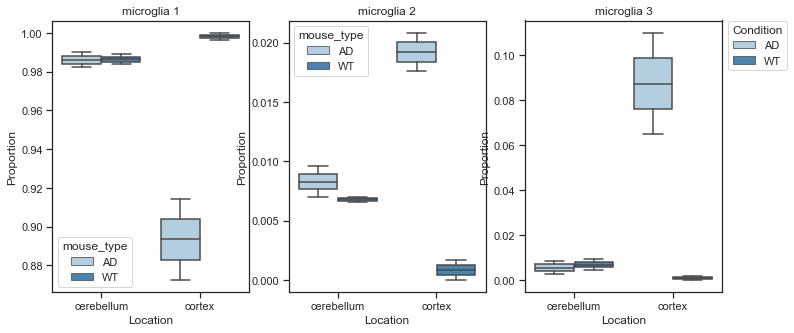

In [23]:
# Count data to ratios
counts = cell_counts.iloc[:, 3:]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["mouse_type"] = cell_counts["mouse_type"]
ratios["location"] = cell_counts["location"]

# Make boxplots
fig, ax = plt.subplots(figsize=(12,5), ncols=3)
df = pd.melt(ratios, id_vars=['location', "mouse_type"], value_vars=ratios.columns[:3])
print(df)
sns.set_context('notebook')
sns.set_style('ticks')
for i in range(3):
    d = sns.boxplot(x='location', y = 'value', hue="mouse_type",
                    data=df.loc[df["variable"]==f"microglia {i+1}"], fliersize=1,
                    palette='Blues', ax=ax[i])

    d.set_ylabel('Proportion')
    loc, labels = plt.xticks()
    d.set_xlabel('Location')
    d.set_title(f"microglia {i+1}")
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

# plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Analyze cerebellum data:
Apply SCDCdm for every cell type set as the reference.

In [61]:
# cerebellum
res_cer = []
effects_cer = pd.DataFrame(index=data_cer.var.index,
                       columns=data_cer.var.index)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cer, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cer.append(results)
    effects_cer[ct] = effect_df.loc[:, "Final Parameter"].array
  

Reference: microglia 1
MCMC sampling finished. (118.310 sec)
Acceptance rate: 7.4%
Reference: microglia 2
MCMC sampling finished. (130.931 sec)
Acceptance rate: 1.6%
Reference: microglia 3
MCMC sampling finished. (126.731 sec)
Acceptance rate: 9.2%


In [62]:
# Column: Reference category
# Row: Effect
print(effects_cer)
    

             microglia 1  microglia 2  microglia 3
microglia 1     0.000000    11.135994     0.532325
microglia 2    17.429338     0.000000     0.170717
microglia 3    13.028741     1.870725     0.000000


Now with cortex data:

In [63]:
# cortex
res_cor = []
effects_cor = pd.DataFrame(index=data_cer.var.index,
                         columns=data_cer.var.index)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cor, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cor.append(results)
    effects_cor[ct] = effect_df.loc[:, "Final Parameter"].array
    

Reference: microglia 1
MCMC sampling finished. (140.934 sec)
Acceptance rate: 45.8%
Reference: microglia 2
MCMC sampling finished. (176.110 sec)
Acceptance rate: 42.5%
Reference: microglia 3
MCMC sampling finished. (149.499 sec)
Acceptance rate: 2.4%


In [64]:
# Column: Reference category
# Row: Effect
print(effects_cor)


             microglia 1  microglia 2  microglia 3
microglia 1     0.000000    17.077913    16.966148
microglia 2    -2.112572     0.000000    23.163162
microglia 3    -3.016429     6.041350     0.000000


Trying out: Add pseudocount of 10 to all entries
--> This really improves the results (acceptable inc.prob in all but one case)

In [3]:
# cesebellum with pseudocount
data_cer_10 = data_cer
data_cer_10.X = data_cer_10.X + 10
print(data_cer_10.X)

res_cer_10 = []
effects_cer_10 = pd.DataFrame(index=data_cer_10.var.index,
                       columns=data_cer_10.var.index)

for ct in data_cer_10.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cer_10, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cer_10.append(results)
    effects_cer_10[ct] = effect_df.loc[:, "Final Parameter"].array
  


[[719.  15.  12.]
 [725.  17.  16.]
 [459.  13.  12.]
 [434.  13.  14.]]
Reference: microglia 1
MCMC sampling finished. (125.477 sec)
Acceptance rate: 48.5%
Reference: microglia 2
MCMC sampling finished. (137.884 sec)
Acceptance rate: 9.2%
Reference: microglia 3
MCMC sampling finished. (137.559 sec)
Acceptance rate: 57.6%


In [4]:
# Column: Reference category
# Row: Effect
print(effects_cer_10)

             microglia 1  microglia 2  microglia 3
microglia 1          0.0          0.0    -0.429604
microglia 2          0.0          0.0     0.000000
microglia 3          0.0          0.0     0.000000


In [5]:
# Cortex with pseudocount
data_cor_10 = data_cor
data_cor_10.X = data_cor_10.X + 10
print(data_cor_10.X)

res_cor_10 = []
effects_cor_10 = pd.DataFrame(index=data_cor_10.var.index,
                       columns=data_cor_10.var.index)

for ct in data_cor_10.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cor_10, formula="mouse_type", baseline_index=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cor_10.append(results)
    effects_cor_10[ct] = effect_df.loc[:, "Final Parameter"].array
  


[[844.  29.  69.]
 [804.  26. 110.]
 [422.  10.  10.]
 [591.  11.  11.]]
Reference: microglia 1
MCMC sampling finished. (186.077 sec)
Acceptance rate: 46.6%
Reference: microglia 2
MCMC sampling finished. (169.748 sec)
Acceptance rate: 49.5%
Reference: microglia 3
MCMC sampling finished. (148.113 sec)
Acceptance rate: 61.7%


In [6]:
# Column: Reference category
# Row: Effect
print(effects_cor_10)

             microglia 1  microglia 2  microglia 3
microglia 1     0.000000     0.789159     1.447606
microglia 2     0.000000     0.000000     1.076984
microglia 3    -1.423657    -1.226091     0.000000
